In [1]:
import os
import xarray as xr
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib as mpl
from tools.tools import save2nc
import tools.config as config
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


# 1. 使用 Seaborn 设置基础网格和颜色主题
sns.set_theme(style="darkgrid")

# 2. 设置常规文本字体 (例如 Arial)
#    这会影响标题、坐标轴标签等非 mathtext 元素
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# 3. 将可能被修改过的 mathtext 设置恢复到 Matplotlib 的默认状态。
#    这是一个安全的赋值操作，而不是不稳定的 pop 操作。
#    默认的 mathtext 字体是 'dejavusans'，默认模式是 'it' (斜体)。
mpl.rcParams['mathtext.rm'] = 'dejavusans'
mpl.rcParams['mathtext.default'] = 'it'

# 4. 现在，覆盖 mathtext 的字体集，让它使用与 Arial 外观相似的 'stixsans'。
#    这是实现字体统一外观的关键步骤，并且非常稳定。
plt.rcParams['mathtext.fontset'] = 'stixsans'

# 5. 应用您其他的自定义样式
plt.rcParams.update({
    "xtick.bottom": True, "ytick.left": True,
    "xtick.top": False, "ytick.right": False,
    "xtick.direction": "out", "ytick.direction": "out",
    "xtick.major.size": 4, "ytick.major.size": 4,
    "xtick.major.width": 1.2, "ytick.major.width": 1.2,
})

def set_plot_style(font_size=12, font_family='Arial'):
    """
    统一设置 Matplotlib 的全局绘图风格。

    这个函数会更新 rcParams，以确保图表中的所有文本元素
    （标题、标签、刻度、图例等）都使用一致的字体和大小。

    参数:
        font_size (int): 基础字号，应用于所有文本元素。
        font_family (str): 字体族，例如 'Arial', 'Helvetica', 'Times New Roman'。
    """
    # mpl.rcParams.update() 是一种高效地一次性更新多个参数的方法。
    mpl.rcParams.update({
        # --- 全局字体设置 ---
        'font.size': font_size,           # 设置基础字号
        'font.family': 'sans-serif',      # 推荐设置字体“族”为无衬线
        'font.sans-serif': [font_family, 'DejaVu Sans'], # 提供一个字体备选列表，Arial优先

        # --- 坐标轴(Axes)相关字体大小 ---
        'axes.titlesize': font_size,      # 子图标题 (ax.set_title())
        'axes.labelsize': font_size,      # 子图X/Y轴标签 (ax.set_xlabel())

        # --- 刻度(Ticks)相关字体大小 ---
        'xtick.labelsize': font_size,     # X轴刻度标签
        'ytick.labelsize': font_size,     # Y轴刻度标签

        # --- 图例(Legend)字体大小 ---
        'legend.fontsize': font_size,

        # --- 图表(Figure)级别字体大小 ---
        # 这个参数同时控制 fig.suptitle() 和 fig.supylabel()
        'figure.titlesize': font_size
    })

def create_profit(excel_path: str) -> pd.DataFrame:
    original_df = pd.read_excel(excel_path, index_col=0)
    profit_df = pd.DataFrame()

    # 规则 1: Ag profit = Ag revenue - Ag cost
    profit_df['Ag profit'] = original_df['Ag revenue'] - original_df['Ag cost']
    
    # 规则 2: Agmgt profit = Agmgt revenue - Agmgt cost
    profit_df['Agmgt profit'] = original_df['Agmgt revenue'] - original_df['Agmgt cost']
    
    # 规则 3: Non-ag profit = Non-ag revenue - Non-ag cost
    profit_df['Non-ag profit'] = original_df['Non-ag revenue'] - original_df['Non-ag cost']
    
    # 规则 4: Transition(ag→ag) profit = 0 - Transition(ag→ag) cost
    profit_df['Transition(ag→ag) profit'] = 0 - original_df['Transition(ag→ag) cost']
    
    # 规则 5: Transition(ag→non-ag) amortised profit = 0 - Transition(ag→non-ag) amortised cost
    profit_df['Transition(ag→non-ag) amortised profit'] = 0 - original_df['Transition(ag→non-ag) amortised cost']
    return profit_df

def stacked_area_pos_neg(
        ax, df, colors=None, alpha=0.60,
        title_name='', ylabel='',n_bins=5,
        add_line=True, n_col=1, show_legend=False, bbox_to_anchor=(0.5, -0.25)
):
    """
    绘制一个可以同时显示正值和负值的堆叠面积图。

    此函数假定：
    - 如果 add_line=True，则输入 DataFrame `df` 的最后一列是预先计算好的总和/合计。
    - 除了最后一列之外的所有列都是用于堆叠的子项。

    Args:
        ax: Matplotlib的Axes对象，用于在其上绘图。
        df (pd.DataFrame): 包含绘图数据的DataFrame。
        colors (list, optional): 用于堆叠区域的颜色列表。
        alpha (float, optional): 填充颜色的透明度。
        title_name (str, optional): 图表标题。
        ylabel (str, optional): Y轴标签。
        add_line (bool, optional): 是否绘制代表总和的线条（使用df的最后一列）。
        n_col (int, optional): 图例的列数。
        show_legend (bool, optional): 是否显示图例。
        bbox_to_anchor (tuple, optional): 控制图例位置的参数。
    """
    # ---- 1. 数据分离：分离堆叠项和总和项 ----
    df_stack = df.iloc[:, :-1]  # 所有列，除了最后一列
    total_col_name = df.columns[-1]
    total_col_data = df.iloc[:, -1]

    # ---- 2. 可选总和线 (使用预计算的最后一列) ----
    if add_line:
        ax.plot(
            df.index, total_col_data,  # 使用最后一列的数据
            linestyle='-', marker='o',
            color='black', linewidth=2,
            markersize=5, markeredgewidth=1,
            markerfacecolor='black', markeredgecolor='black',
            label=total_col_name  # 使用最后一列的名称作为标签
        )

    # ---- 3. 颜色管理 ----
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if len(colors) < df_stack.shape[1]:
        # 根据堆叠项的数量来确定颜色
        num_stack_cols = df_stack.shape[1]
        colors = (colors * (num_stack_cols // len(colors) + 1))[:num_stack_cols]

    # ---- 4. 堆叠面积图 (仅使用 df_stack) ----
    cum_pos = np.zeros(len(df_stack))
    cum_neg = np.zeros(len(df_stack))
    # **关键修改**：只遍历 df_stack 的列
    for idx, col in enumerate(df_stack.columns):
        y = df_stack[col].values
        pos = np.clip(y, 0, None)
        neg = np.clip(y, None, 0)
        colr = colors[idx]
        ax.fill_between(df_stack.index, cum_pos, cum_pos + pos,
                        facecolor=colr, alpha=alpha, linewidth=0, label=col)
        cum_pos += pos
        ax.fill_between(df_stack.index, cum_neg, cum_neg + neg,
                        facecolor=colr, alpha=alpha, linewidth=0)
        cum_neg += neg

    # ---- 5. 轴和外观 ----
    ax.yaxis.set_major_locator(MaxNLocator(nbins=n_bins, prune='both'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.set_xlim(df.index.min(), df.index.max())

    ax.set_title(title_name, pad=6)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('')
    ax.tick_params(direction='out')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.2)

    # ---- 6. 图例处理 ----
    handles, labels = ax.get_legend_handles_labels()
    unique = {}
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h

    # 确保总和线在图例的最后
    if add_line and total_col_name in unique:
        total_handle = unique.pop(total_col_name)
        final_labels = list(unique.keys()) + [total_col_name]
        final_handles = list(unique.values()) + [total_handle]
    else:
        final_labels = list(unique.keys())
        final_handles = list(unique.values())

    if show_legend:
        ax.legend(
            handles=final_handles, labels=final_labels,
            loc='upper left', bbox_to_anchor=bbox_to_anchor,
            frameon=False, ncol=n_col,
            handlelength=1.0, handleheight=1.0,
            handletextpad=0.4, labelspacing=0.3
        )

    return ax

def draw_legend(ax, bbox_to_anchor=(0.85, 0.69), ncol=2, column_spacing=1.0):
    """
    绘制调整过布局的图例。
    - bbox_to_anchor 控制整体位置 (x=0.85 使其左移)。
    - ncol=2 设置为两列。
    - column_spacing=1.0 减小列间距。
    """
    fig = ax.get_figure()
    handles, labels = ax.get_legend_handles_labels()

    # ... (创建 new_handles 的代码保持不变) ...
    new_handles = []
    for h in handles:
        if isinstance(h, Patch):
            new_handles.append(
                Patch(facecolor=h.get_facecolor(), edgecolor=h.get_edgecolor(), linewidth=h.get_linewidth()))
        elif isinstance(h, Line2D):
            new_handles.append(Line2D([0], [0], color=h.get_color(), linestyle=h.get_linestyle(),
                                      linewidth=h.get_linewidth(), marker=h.get_marker(),
                                      markersize=h.get_markersize(), markerfacecolor=h.get_markerfacecolor(),
                                      markeredgecolor=h.get_markeredgecolor()))
        else:
            new_handles.append(h)

    # 关键修改：应用新的布局参数
    fig.legend(handles=new_handles, labels=labels, loc='upper center',
               bbox_to_anchor=bbox_to_anchor,
               ncol=ncol,
               frameon=False,
               handlelength=1.0,
               handleheight=1.0,
               handletextpad=0.4,
               labelspacing=0.3,
               columnspacing=column_spacing  # <--- 控制列间距
               )

def draw_legend(ax, bbox_to_anchor=(0.85, 0.69), ncol=2, column_spacing=1.0):
    """
    绘制调整过布局的图例。
    - bbox_to_anchor 控制整体位置 (x=0.85 使其左移)。
    - ncol=2 设置为两列。
    - column_spacing=1.0 减小列间距。
    """
    fig = ax.get_figure()
    handles, labels = ax.get_legend_handles_labels()

    # ... (创建 new_handles 的代码保持不变) ...
    new_handles = []
    for h in handles:
        if isinstance(h, Patch):
            new_handles.append(
                Patch(facecolor=h.get_facecolor(), edgecolor=h.get_edgecolor(), linewidth=h.get_linewidth()))
        elif isinstance(h, Line2D):
            new_handles.append(Line2D([0], [0], color=h.get_color(), linestyle=h.get_linestyle(),
                                      linewidth=h.get_linewidth(), marker=h.get_marker(),
                                      markersize=h.get_markersize(), markerfacecolor=h.get_markerfacecolor(),
                                      markeredgecolor=h.get_markeredgecolor()))
        else:
            new_handles.append(h)

    # 关键修改：应用新的布局参数
    fig.legend(handles=new_handles, labels=labels, loc='upper center',
               bbox_to_anchor=bbox_to_anchor,
               ncol=ncol,
               frameon=False,
               handlelength=1.0,
               handleheight=1.0,
               handletextpad=0.4,
               labelspacing=0.3,
               columnspacing=column_spacing  # <--- 控制列间距
               )

task_name = config.TASK_NAME
base_path = f"../../../output/{task_name}/carbon_price/0_base_data"
excel_path = f"../../../output/{task_name}/carbon_price/1_excel"
figure_path = f"../../../output/{task_name}/carbon_price/3_Paper_figure"

In [2]:
input_files_1 = config.input_files_1
input_files_2 = config.input_files_2

title_carbon_names =  [
    '$\mathrm{GHG}_{\mathrm{low}}$',
    '$\mathrm{GHG}_{\mathrm{high}}$']

title_bio_names =  [
    '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{10}}$',
    '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{20}}$',
    '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{30}}$',
    '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{40}}$',
    '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{50}}$',

    '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{10}}$',
    '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{20}}$',
    '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{30}}$',
    '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{40}}$',
    '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{50}}$'
]

all_carbon = []
for input_file in input_files_1:
    df = pd.read_excel(os.path.join(excel_path, f'0_Origin_carbon_{input_file}.xlsx'), index_col=0)
    df.columns = df.columns.str.replace(' GHG', '')
    new_rows_list = []

    # 从第二行开始循环 (索引 i 从 1 到 df 的末尾)
    for i in range(1, len(df)):
        # 取出当前行并取负
        new_row = df.iloc[i].copy()
        new_row = new_row * -1
        
        # 关键步骤：新行的第一列 = (原值取负) + (原df中上一行第一列的值)
        new_row.iloc[0] = -df.iloc[i, 0] + df.iloc[i-1, 0]
        
        # 将计算出的新行（这是一个 Series）添加到列表中
        new_rows_list.append(new_row)
    
    # 使用收集到的行列表一次性创建新的 DataFrame
    # 这样做比在循环中反复 concat 更高效
    new_df = pd.DataFrame(new_rows_list)
    
    # 将新 DataFrame 的索引设置为与原数据对应（从 1 开始）
    new_df.index = df.index[1:]
    new_df['Total'] = new_df.sum(axis=1)
    new_df.to_excel(os.path.join(excel_path, f'1_Processed_carbon_{input_file}.xlsx'))
    new_df = new_df.loc[new_df.index >= config.START_YEAR].copy()
    all_carbon.append(new_df)
all_bio = []
for input_file in input_files_2:
    df = pd.read_excel(os.path.join(excel_path, f'0_Origin_biodiversity_{input_file}.xlsx'), index_col=0)
    df.columns = df.columns.str.replace(' biodiversity', '')
    new_rows_list = []

    # 从第二行开始循环 (索引 i 从 1 到 df 的末尾)
    for i in range(1, len(df)):
        # 取出当前行并取负
        new_row = df.iloc[i].copy()
        
        new_row.iloc[0] = df.iloc[i, 0] - df.iloc[i-1, 0]
        
        # 将计算出的新行（这是一个 Series）添加到列表中
        new_rows_list.append(new_row)
    
    # 使用收集到的行列表一次性创建新的 DataFrame
    # 这样做比在循环中反复 concat 更高效
    new_df = pd.DataFrame(new_rows_list)
    
    # 将新 DataFrame 的索引设置为与原数据对应（从 1 开始）
    new_df.index = df.index[1:]
    new_df['Total'] = new_df.sum(axis=1)
    new_df.to_excel(os.path.join(excel_path, f'1_Processed_bio_{input_file}.xlsx'))
    new_df = new_df.loc[new_df.index >= config.START_YEAR].copy()
    all_bio.append(new_df)

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape 

In [3]:
colors_carbon = ['#f8e17e', '#f5825c', '#4da5a8', '#b44384']
carbon_ymin = min(df['Total'].min() for df in all_carbon)
carbon_ymax = max(df['Total'].max() for df in all_carbon)

colors_bio = ['#f8e17e', '#f5825c', '#4da5a8']
bio_ymin = min(df['Total'].min() for df in all_bio)
bio_ymax = max(df['Total'].max() for df in all_bio)

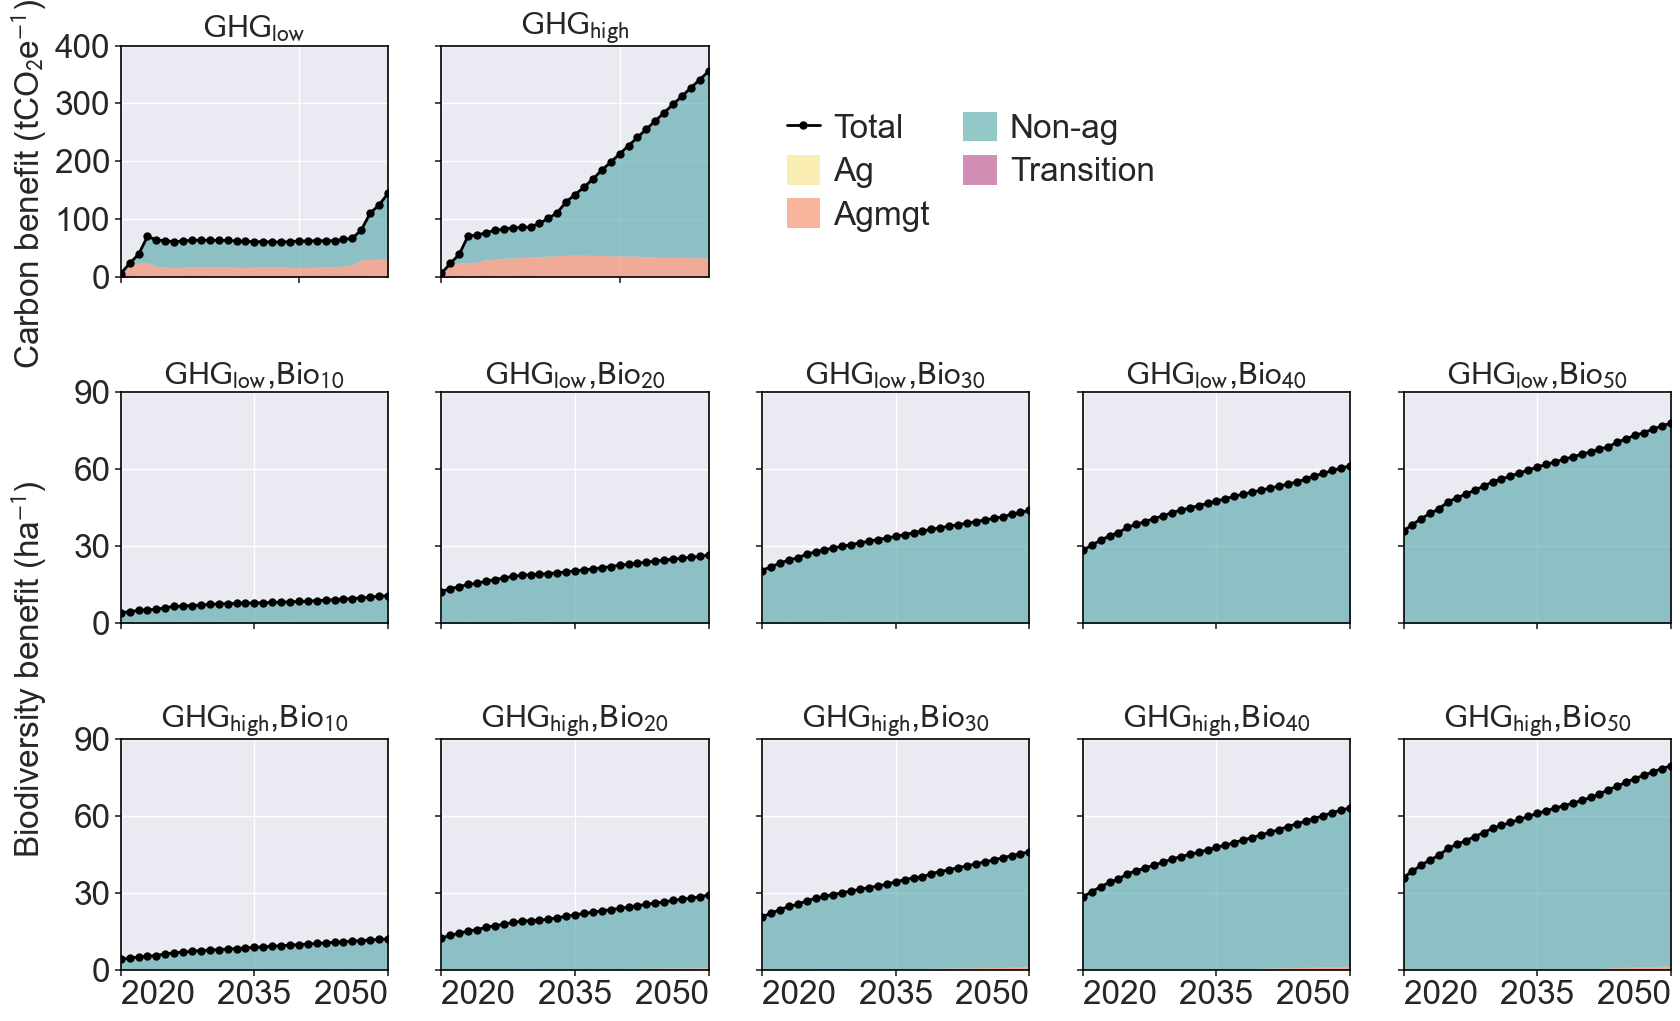

In [4]:
# --- 4. 创建 3x5 子图布局 ---
set_plot_style(font_size=24)
fig = plt.figure(figsize=(20, 12))

# 步骤 1: 创建一个 3x5 的主网格
gs = gridspec.GridSpec(3, 5, figure=fig, hspace=0.5, wspace=0.2)

# --- 绘制 Carbon 图 (第一行前两个) ---
ax_carbon_list = []
for i in range(2):
    ax = fig.add_subplot(gs[0, i])
    stacked_area_pos_neg(ax, all_carbon[i], colors_carbon, title_name=title_carbon_names[i])
    ax.set_ylim(carbon_ymin, carbon_ymax)
    x_data = all_bio[i].index
    start_tick, middle_tick, end_tick = x_data.min(), x_data[len(x_data) // 2], x_data.max()
    tick_positions = [start_tick, middle_tick, end_tick]
    ax.tick_params(axis='x', labelbottom=False)
    ax_carbon_list.append(ax)

# 设置共享Y轴，并控制刻度标签
# 修改 GHGhigh 图的 Y 轴刻度
ax_carbon_list[1].set_yticks([0, 100, 200, 300, 400])
ax_carbon_list[0].sharey(ax_carbon_list[1])
ax_carbon_list[1].tick_params(axis='y', labelleft=False) # 只让最左边的显示Y刻度

# --- 创建图例区域 (第一行后三个合并) ---
legend_ax = fig.add_subplot(gs[0, 2:]) # 使用切片 gs[0, 2:] 来合并单元格
legend_ax.axis('off') # 关闭坐标轴


# --- 绘制 Bio 图 (后两行) ---
ax_bio_list = []
shared_bio_ax = None # 用于共享Y轴的参考轴

for i in range(10):
    row = i // 5 + 1 # +1 让行号从 1 和 2 开始 (主网格的第二、三行)
    col = i % 5
    
    # 共享Y轴的设置
    if shared_bio_ax is None:
        ax = fig.add_subplot(gs[row, col])
        shared_bio_ax = ax # 第一个bio图作为共享Y轴的基准
    else:
        ax = fig.add_subplot(gs[row, col], sharey=shared_bio_ax)

    stacked_area_pos_neg(ax, all_bio[i], colors_bio, title_name=title_bio_names[i])
    # set_ylim 会被 sharey 覆盖，所以只需在基准轴上设置一次即可
    
    # 控制Y轴刻度：只在最左边一列 (col==0) 显示
    if col != 0:
        ax.tick_params(axis='y', labelleft=False)
        
    # 控制X轴刻度：只在最下面一行 (row==2) 显示
    x_data = all_bio[i].index
    start_tick, middle_tick, end_tick = x_data.min(), x_data[len(x_data) // 2], x_data.max()
    tick_positions = [start_tick, middle_tick, end_tick]

    ax.set_xticks(tick_positions)
    if row == 2:
        # 如果是，则设置三个刻度并微调对齐方式

        ax.tick_params(axis='x')  # 在这里设置您想要的字体大小

        # 获取标签并修改对齐方式
        x_labels = ax.get_xticklabels()
        if len(x_labels) >= 3:
            x_labels[0].set_horizontalalignment('left')
            x_labels[-1].set_horizontalalignment('right')
    else:
        # **关键补充**：如果不是最下面一行，则明确地隐藏X轴的刻度标签
        ax.tick_params(axis='x', labelbottom=False)
    
    ax_bio_list.append(ax)

# 在基准轴上设置Y轴范围
# shared_bio_ax.set_ylim(bio_ymin, bio_ymax)
shared_bio_ax.set_ylim(0, 90)
shared_bio_ax.set_yticks([0, 30,60,90])


# --- 5. 添加全局Y轴标签 ---
ax_carbon_list[0].set_ylabel(r"Carbon benefit (tCO$_2$e$^{-1}$)", y=0.4) 
ax_bio_list[0].set_ylabel(r"Biodiversity benefit (ha$^{-1}$)", y=-0.2) 
fig.align_ylabels([ax_carbon_list[0], ax_bio_list[0]])

draw_legend(ax_carbon_list[0], bbox_to_anchor=(0.55, 0.85), ncol=2)
plt.savefig(os.path.join(figure_path, '05_Carbon&bio.png'), dpi=300, bbox_inches='tight')
plt.show()